# Homework #2: Music Auto Tagging (Multi-Label Classification and Metric Learning Approach)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems. 

Two central methods for representation learning include deep metric learning and classification, both having the same goal of learning a representation that can generalize well across tasks.

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

# Getting Ready

## Preparing The Dataset
We use the [magnatagatune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) dataset which has been the most widely used in the music tagging task.  The MagnaTagATune dataset consists of 25k music
clips from 6,622 unique songs.

The dataset contains 30-second audio files including 189 different tags
For this homework, we are going to use a magnatagatune with 8-second audio and only 50 genres.

We use subset of magnatagatune dataset (9074 samples x 8 sec).

To make your life easier, place them in a directory as below:

```
├── annotations_final.csv
├── waveform
  ├── 1
  ├── ...
  └── d
```

## Importing Packages

In [1]:
import warnings
import multiprocessing
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import os
import torchaudio
import torch
import torch.nn as nn
from sklearn import metrics

from tqdm.notebook import tqdm
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import IPython.display as ipd

## Enabling and testing the GPU

First, you'll need to enable GPUs for the Colab notebook:

- Navigate to Edit (수정) → Notebook Settings (노트 설정)
- select GPU from the Hardware Accelerator (하드웨어 가속기) drop-down

Next, we'll confirm that we can connect to the GPU with PyTorch and check versions of packages:

In [2]:
if not torch.cuda.is_available():
  raise SystemError('GPU device not found!')
print(f'Found GPU at: {torch.cuda.get_device_name()}')
print(f'PyTorch version: {torch.__version__}')
print(f'Torch Audio version: {torchaudio.__version__}')

Found GPU at: TITAN Xp
PyTorch version: 1.9.0
Torch Audio version: 0.9.0


If the cell above throws an error, then you should enable the GPU following the instruction above!

# Data Checking


In [3]:
# use 50 top tags
TAGS = ['guitar','classical', 'slow','techno','strings','drums','electronic','rock',
        'fast','piano','ambient','beat','violin','vocal','synth','female','indian',
        'opera','male','singing','vocals','no vocals','harpsichord','loud','quiet',
        'flute', 'woman', 'male vocal', 'no vocal', 'pop','soft','sitar', 'solo',
        'man', 'classic', 'choir', 'voice', 'new age', 'dance', 'male voice',
        'female vocal', 'beats', 'harp', 'cello', 'no voice', 'weird', 'country',
        'metal', 'female voice', 'choral']

In [4]:
df = pd.read_csv("./annotations_final.csv", sep="\t", index_col=0)
item = df.iloc[0]
item[item != 0] # check annotated tags

classical                                                    1
strings                                                      1
opera                                                        1
violin                                                       1
mp3_path     f/american_bach_soloists-j_s__bach_solo_cantat...
Name: 2, dtype: object

In [5]:
# filter out, un-annnotated dataset
df_filter =  df[TAGS].sum(axis=1)
use_id = df_filter[df_filter != 0].index
df = df.loc[use_id]

<AxesSubplot:>

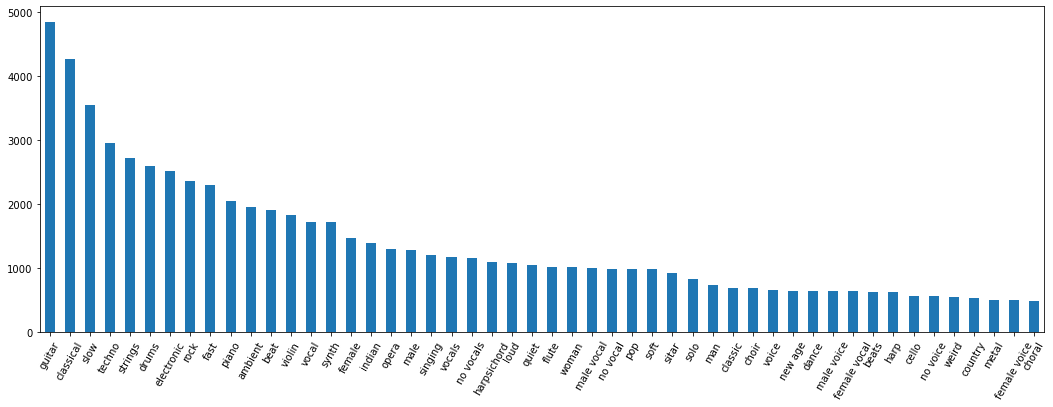

In [6]:
df[TAGS].sum().plot.bar(figsize=(18,6),rot=60) # check data distribution

# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [7]:
train = []
valid = []
test = []
id_to_path = {}
for idx in range(len(df)):
  item = df.iloc[idx]
  id = item.name
  path = item['mp3_path']
  folder = path.split("/")[0]
  id_to_path[id] = path
  if folder in "012ab":
    train.append(id)# split = "train"
  elif folder == "c":    
    valid.append(id)# split = "valid"
  elif folder in "d":
    test.append(id)# split = "test"

In [8]:
total = len(train) + len(valid) + len(test)
total, len(train) / total, len(valid)/ total, len(test)/ total

(9074, 0.6839321137315406, 0.16850341635441923, 0.14756446991404013)

In [9]:
df = df[TAGS]

In [10]:
df_train = df.loc[train]
df_valid = df.loc[valid]
df_test = df.loc[test]

In [11]:
# Data processing setup.
SR = 16000
BATCH_SIZE = 16

## Dataset & DataLoader

In [12]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class AudioDataset(Dataset):
  def __init__(self, paths, input_length, binary, id_to_path, split, augmentation):
    """
    Args:
      paths (str): path to load dataset from
      input_length (int): sample_rate x duration (second) 
      binary (Pandas.DataFrame): binary matrix for audio (index: track_id, columns: tag binary)
      id_to_path (Dict): track id to audio path
      split (str): one of [TRAIN, VALID, TEST]
    """
    self.paths = paths
    self.input_length = input_length
    self.binary = binary
    self.id_to_path = id_to_path
    self.split = split
    self.augmentation = augmentation
    
  def __getitem__(self, index):
    item = self.binary.iloc[index]
    waveform = self.item_to_waveform(item)
    if self.augmentation == "original":
        return waveform.astype(np.float32), item.values.astype(np.float32) 
    elif self.augmentation == "noise":
        noise = np.random.randn(waveform.shape[1])
        waveform = waveform + 0.001 * noise
        return waveform.astype(np.float32), item.values.astype(np.float32) 
    elif self.augmentation == "shift":
        waveform[0,:] = np.roll(waveform[0,:], int(waveform.shape[1]/8))        
        return waveform.astype(np.float32), item.values.astype(np.float32) 
  
  def item_to_waveform(self, item):
    id = item.name
    path = os.path.join(self.paths, self.id_to_path[id].replace(".mp3", ".npy")) # pre-extract waveform, for fast loader
    waveform = np.load(path) 
    if self.split in ['TRAIN','VALID']:
      random_idx = np.random.randint(low=0, high=int(waveform.shape[0] - self.input_length))
      waveform = waveform[random_idx:random_idx+self.input_length] # extract input
      audio = np.expand_dims(waveform, axis = 0)# 1 x samples
    elif self.split == 'TEST':
      chunk_number = waveform.shape[0] // self.input_length
      chunk = np.zeros((chunk_number, self.input_length))
      for idx in range(chunk.shape[0]):
        chunk[idx] = waveform[idx * input_length:(idx+1) * input_length] # Thanks for JoonkyuPark :)
      audio = chunk
    return audio
      
  def __len__(self):
    return len(self.binary)

### Computing statistics of the training set
The code below compute mean, standard deviation and the minimum temporal dimension size, and use them for preprocessing inputs.

In [13]:
BATCH_SIZE = 16
num_workers = 0 #2
sample_rate = 16000
duration = 3
input_length =  sample_rate * duration
data_path = "./waveform"
tr_data = AudioDataset(data_path, input_length, df_train, id_to_path, 'TRAIN', "original")
va_data = AudioDataset(data_path, input_length, df_valid, id_to_path, 'VALID', "original")
te_data = AudioDataset(data_path, input_length, df_test, id_to_path, 'TEST', "original")
loader_train = DataLoader(tr_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = DataLoader(va_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(te_data, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False) # for chunk inference

## Training a baseline
The table below shows the architecture of the baseline.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x 16000 * sec,    | batch x channel x samples |
| mel_spec       | B x 96 x 188    | batch x freq x time|
| conv + maxpool | B x 32 x 64    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 22    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 8     | kernel_size=3 stride=1 |
| global_avgpool | B x 32 x 1     | -                       |
| classifier     | B x 50         | -                       |

The class below is an implementation of it:

In [14]:
import torch.nn as nn

class Baseline(nn.Module):
  def __init__(self,
              sample_rate=16000,
              n_fft=512,
              f_min=0.0,
              f_max=8000.0,
              n_mels=96,
              n_class=50):
    """
    Args:
      sample_rate (int): path to load dataset from
      n_fft (int): number of samples for fft
      f_min (float): min freq
      f_max (float): max freq
      n_mels (float): number of mel bin
      n_class (int): number of class
    """
    super(Baseline, self).__init__()
    # Spectrogram
    self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                      n_fft=n_fft,
                                                      f_min=f_min,
                                                      f_max=f_max,
                                                      n_mels=n_mels)
    self.to_db = torchaudio.transforms.AmplitudeToDB()
    self.spec_bn = nn.BatchNorm2d(1)
    
    self.conv0 = nn.Sequential(
        nn.Conv1d(n_mels, out_channels=32, kernel_size=3, stride=1, padding=3),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3, stride=3)
        )

    self.conv1 = nn.Sequential(
        nn.Conv1d(32, out_channels=32, kernel_size=3, stride=1, padding=3),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3, stride=3)
        )

    self.conv2 = nn.Sequential(
        nn.Conv1d(32, out_channels=32, kernel_size=3, stride=1, padding=3),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3, stride=3)
        )
    # Aggregate features over temporal dimension.
    self.final_pool = nn.AdaptiveAvgPool1d(1)
    # Predict tag using the aggregated features.
    self.linear = nn.Linear(32, n_class)

  def forward(self, x):
    x = self.spec(x)
    x = self.to_db(x)
    x = self.spec_bn(x)
    x = x.squeeze(1) # for 1D conv
    x = self.conv0(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.final_pool(x)
    x = self.linear(x.squeeze(-1))
    x = nn.Sigmoid()(x) # for binary cross entropy loss
    return x

In [15]:
class Runner(object):
  def __init__(self, model, lr, momentum, weight_decay, sr, tags):
    """
    Args:
      model (nn.Module): pytorch model
      lr (float): learning rate
      momentum (float): momentum
      weight_decay (float): weight_decay
      sr (float): stopping rate
      tags (list): tags with index
    """
    self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=5, verbose=True)
    self.learning_rate = lr
    self.stopping_rate = sr
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model = model.to(self.device)
    self.criterion = torch.nn.BCELoss().to(self.device)
    self.tags = tags

  # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
  def run(self, dataloader, epoch, mode='TRAIN', augmentation='original'):
    self.model.train() if mode is 'TRAIN' else self.model.eval()

    epoch_loss = 0
    pbar = tqdm(dataloader, desc=f'{mode+"("+augmentation+")"} Epoch {epoch:02}')  # progress bar
    for x, y in pbar:
      # Move mini-batch to the desired device.
      x = x.to(self.device)
      y = y.to(self.device)
      # Feed forward the model.
      prediction = self.model(x)
      # Compute the loss.
      loss = self.criterion(prediction, y)
      if mode is 'TRAIN':
        # Perform backward propagation to compute gradients.
        loss.backward()
        # Update the parameters.
        self.optimizer.step()
        # Reset the computed gradients.
        self.optimizer.zero_grad()

      batch_size = len(x)
      epoch_loss += batch_size * loss.item()
    epoch_loss = epoch_loss / len(dataloader.dataset)
    return epoch_loss 

  def test(self, dataloader):
    self.model.eval()
    epoch_loss = 0
    predictions = []
    labels = []
    pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
    for x, y in pbar:      
      x = x.to(self.device)
      y = y.to(self.device)
      x = x.transpose(1,0) # pre-batch in audio loader (chunk, 1, waveform)
      prediction = self.model(x)
      prediction = prediction.mean(dim=0, keepdim=True) # average chunk audio
      loss = self.criterion(prediction, y) 
      batch_size = len(x)
      epoch_loss += batch_size * loss.item()
      predictions.extend(prediction.detach().cpu().numpy())
      labels.extend(y.detach().cpu().numpy())
    epoch_loss = epoch_loss / len(loader_test.dataset)
    roc_aucs, tag_wise_rocaucs = self.get_auc(predictions, labels)
    return roc_aucs, epoch_loss, tag_wise_rocaucs

  # Early stopping function for given validation loss, you can use this part!
  def early_stop(self, loss, epoch):
    self.scheduler.step(loss, epoch)
    self.learning_rate = self.optimizer.param_groups[0]['lr']
    stop = self.learning_rate < self.stopping_rate
    return stop

  def get_auc(self, predictions, labels):
    roc_aucs  = metrics.roc_auc_score(labels, predictions, average='macro')
    tag_wise_predictions = np.stack(predictions).T
    tag_wise_labels = np.stack(labels).T
    tag_wise_rocaucs = {}
    for tag, logit, label in zip(self.tags, tag_wise_predictions, tag_wise_labels):
      tag_wise_rocaucs[tag] = metrics.roc_auc_score(label, logit)
    return roc_aucs, tag_wise_rocaucs

In [16]:
# Training setup.
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
MOMENTUM = 0.9
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.0  # L2 regularization weight

In [17]:
# Iterate over epochs.
model = Baseline()
runner = Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR, tags=TAGS)
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(loader_train, epoch, 'TRAIN', augmentation='original') 
  valid_loss = runner.run(loader_valid, epoch, 'VALID', augmentation='original')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break

TRAIN(original) Epoch 00:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 00:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 1/10] [Train Loss: 0.6066] [Valid Loss: 0.5059]


TRAIN(original) Epoch 01:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 01:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 2/10] [Train Loss: 0.4231] [Valid Loss: 0.3643]


TRAIN(original) Epoch 02:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 02:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 3/10] [Train Loss: 0.3193] [Valid Loss: 0.2897]


TRAIN(original) Epoch 03:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 03:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 4/10] [Train Loss: 0.2705] [Valid Loss: 0.2603]


TRAIN(original) Epoch 04:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 04:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 5/10] [Train Loss: 0.2474] [Valid Loss: 0.2421]


TRAIN(original) Epoch 05:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 05:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 6/10] [Train Loss: 0.2353] [Valid Loss: 0.2342]


TRAIN(original) Epoch 06:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 06:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 7/10] [Train Loss: 0.2285] [Valid Loss: 0.2276]


TRAIN(original) Epoch 07:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 07:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 8/10] [Train Loss: 0.2239] [Valid Loss: 0.2235]


TRAIN(original) Epoch 08:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 08:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 9/10] [Train Loss: 0.2206] [Valid Loss: 0.2211]


TRAIN(original) Epoch 09:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 09:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 10/10] [Train Loss: 0.2181] [Valid Loss: 0.2185]


In [18]:
roc_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss:.5f},  roc_auc={roc_aucs:.2f}%')

TEST:   0%|          | 0/1339 [00:00<?, ?it/s]

test_loss=0.43774,  roc_auc=0.64%


<AxesSubplot:>

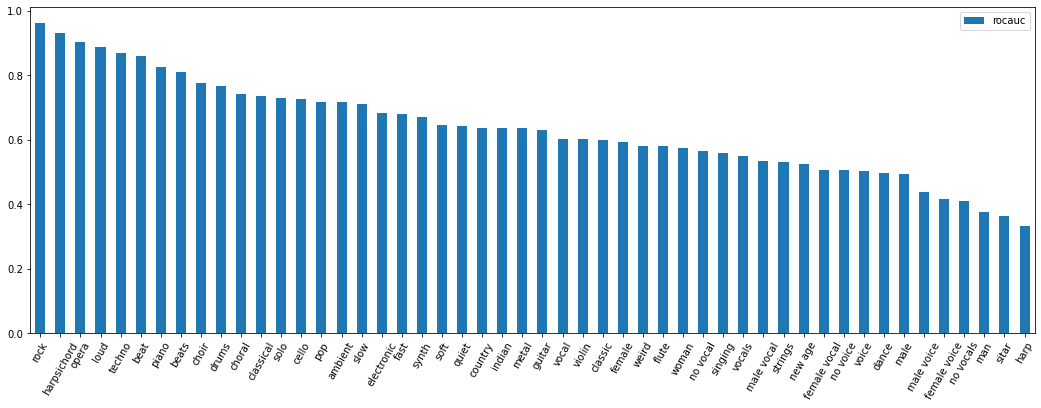

In [19]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task

In [20]:
import pytorch_model_summary 
print(pytorch_model_summary.summary(model, torch.zeros(16, 1, 48000).to('cuda'), show_input=True))

-----------------------------------------------------------------------------
           Layer (type)          Input Shape         Param #     Tr. Param #
       MelSpectrogram-1       [16, 1, 48000]               0               0
        AmplitudeToDB-2     [16, 1, 96, 188]               0               0
          BatchNorm2d-3     [16, 1, 96, 188]               2               2
               Conv1d-4        [16, 96, 188]           9,248           9,248
          BatchNorm1d-5        [16, 32, 192]              64              64
                 ReLU-6        [16, 32, 192]               0               0
            MaxPool1d-7        [16, 32, 192]               0               0
               Conv1d-8         [16, 32, 64]           3,104           3,104
          BatchNorm1d-9         [16, 32, 68]              64              64
                ReLU-10         [16, 32, 68]               0               0
           MaxPool1d-11         [16, 32, 68]               0               

In [21]:
def auto_tagging(waveform, model, input_length, tags, topk):
  """
  Args:
    waveform(np.array) : no channel audio (waveform, )
    model (nn.Module): pytorch model
    input_length (int): sample_rate x duration (second) 
    tags (list): list of tags
    topk (int): tagging number
  """
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = model.to(device)
  chunk_number = waveform.shape[0] // input_length
  chunk = np.zeros((chunk_number, input_length))
  for idx in range(chunk.shape[0]):
    chunk[idx] = waveform[idx * input_length:(idx+1) * input_length]
  audio_tensor = torch.from_numpy(chunk.astype(np.float32))
  predictions = model(audio_tensor.unsqueeze(1).to(device))
  logit = predictions.mean(dim=0, keepdim=False).detach().cpu().numpy()
  annotation = [tags[i] for i in logit.argsort()[::-1][:topk]]
  return annotation

In [22]:
# sample infernece id = 234
id = 224
audio_sample = df_test.loc[id]
waveform = np.load(os.path.join("./waveform",id_to_path[id].replace(".mp3",".npy")))
print("annotation tag: ",list(audio_sample[audio_sample != 0].index))
ipd.Audio(waveform, rate=16000) # load a NumPy array

annotation tag:  ['guitar', 'drums', 'rock', 'loud']


In [23]:
annotation = auto_tagging(waveform, runner.model, input_length, TAGS, 2)
print("model predict tags: ",annotation)

model predict tags:  ['guitar', 'rock']


### [Question 1] Implement the given architecture.
Implement a 2D CNN with the architecture below, train, and report a test accuracy of the 2D CNN.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x sample_rate * duration,    | batch x channel (mono) x samples |
| mel_spec       | B x 1 x 96 x 188    | batch x channel (mono) x freq x time|
| conv + maxpool | B x 64 x 24 x 47    | output_channels=64, kernel_size=3, pooling=(4,4) |
| conv + maxpool | B x 128 x 8 x 15    | output_channels=128, kernel_size=3, pooling=(3,3) |
| conv + maxpool | B x 128 x  2 x 5     | output_channels=128, kernel_size=3 pooling=(3,3) |
| conv + maxpool | B x 64 x 1 x 1      | output_channels=64, kernel_size=3 pooling=(2,5)                    |
| classifier     | B x 50         | -                       |


Note: you should give appropriate paddings! 

In [24]:
import torch.nn as nn

class Conv_2d(nn.Module):
  def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1, pooling=2):
    # To do
    #========================================
    super(Conv_2d, self).__init__()
    self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, 1, padding, bias=True) 
    self.bn = nn.BatchNorm2d(output_channels)
    self.relu = nn.ReLU(inplace=True) 
    self.mp = nn.MaxPool2d(pooling)
    #========================================
  def forward(self, x):
    out = self.mp(self.relu(self.bn(self.conv(x))))
    return out

class CNN2D(nn.Module):
  def __init__(self,
              sample_rate=16000,
              n_fft=512,
              f_min=0.0,
              f_max=8000.0,
              n_mels=96,
              n_class=50):
    super(CNN2D, self).__init__()
    
    # Spectrogram
    self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                      n_fft=n_fft,
                                                      f_min=f_min,
                                                      f_max=f_max,
                                                      n_mels=n_mels)
    self.to_db = torchaudio.transforms.AmplitudeToDB()
    self.spec_bn = nn.BatchNorm2d(1)
    # To do
    #========================================
    self.layer1 = Conv_2d(1, 64, 3, 1, 1, 4)
    self.layer2 = Conv_2d(64, 128, 3, 1, 1, 3)
    self.layer3 = Conv_2d(128, 128, 3, 1, 1, 3)
    self.layer4 = Conv_2d(128, 64, 3, 1, 1, (2,5))
    #========================================
    self.linear = nn.Linear(64, n_class)
    
  def forward(self, x):
    x = self.spec(x)
    x = self.to_db(x)
    x = self.spec_bn(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = x.view(x.size(0), -1)
    x = self.linear(x)
    x = nn.Sigmoid()(x) # for binary cross entropy loss
    return x

In [25]:
# Training setup.
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
MOMENTUM = 0.9
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.0  # L2 regularization weight

In [26]:
# Iterate over epochs.
model = CNN2D()
runner = Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR, tags=TAGS)
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(loader_train, epoch, 'TRAIN', augmentation='original') 
  valid_loss = runner.run(loader_valid, epoch, 'VALID', augmentation='original')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break

TRAIN(original) Epoch 00:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 00:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 1/10] [Train Loss: 0.3175] [Valid Loss: 0.2203]


TRAIN(original) Epoch 01:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 01:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 2/10] [Train Loss: 0.2132] [Valid Loss: 0.2094]


TRAIN(original) Epoch 02:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 02:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 3/10] [Train Loss: 0.2060] [Valid Loss: 0.2045]


TRAIN(original) Epoch 03:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 03:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 4/10] [Train Loss: 0.2023] [Valid Loss: 0.2009]


TRAIN(original) Epoch 04:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 04:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 5/10] [Train Loss: 0.1989] [Valid Loss: 0.1992]


TRAIN(original) Epoch 05:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 05:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 6/10] [Train Loss: 0.1970] [Valid Loss: 0.1973]


TRAIN(original) Epoch 06:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 06:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 7/10] [Train Loss: 0.1947] [Valid Loss: 0.1956]


TRAIN(original) Epoch 07:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 07:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 8/10] [Train Loss: 0.1934] [Valid Loss: 0.1950]


TRAIN(original) Epoch 08:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 08:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 9/10] [Train Loss: 0.1920] [Valid Loss: 0.1938]


TRAIN(original) Epoch 09:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 09:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 10/10] [Train Loss: 0.1898] [Valid Loss: 0.1920]


In [27]:
roc_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss:.5f},  roc_auc={roc_aucs:.2f}%')

TEST:   0%|          | 0/1339 [00:00<?, ?it/s]

test_loss=0.37815,  roc_auc=0.77%


<AxesSubplot:>

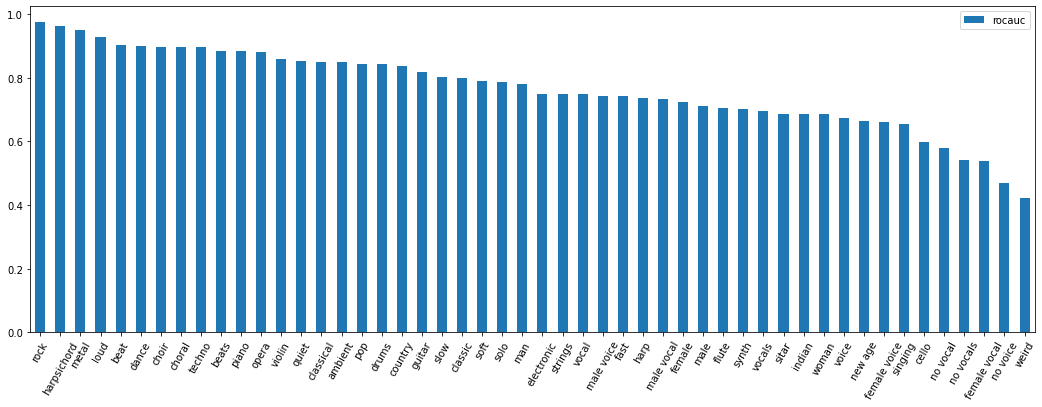

In [28]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task

In [29]:
print(pytorch_model_summary.summary(model, torch.zeros(16, 1, 48000).to('cuda'), show_input=True))

-------------------------------------------------------------------------
       Layer (type)          Input Shape         Param #     Tr. Param #
   MelSpectrogram-1       [16, 1, 48000]               0               0
    AmplitudeToDB-2     [16, 1, 96, 188]               0               0
      BatchNorm2d-3     [16, 1, 96, 188]               2               2
          Conv_2d-4     [16, 1, 96, 188]             768             768
          Conv_2d-5     [16, 64, 24, 47]          74,112          74,112
          Conv_2d-6     [16, 128, 8, 15]         147,840         147,840
          Conv_2d-7      [16, 128, 2, 5]          73,920          73,920
           Linear-8             [16, 64]           3,250           3,250
Total params: 299,892
Trainable params: 299,892
Non-trainable params: 0
-------------------------------------------------------------------------


### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size 
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...). 

* You can also use ResNet or other CNNs with skip connections. 

* Furthermore, you can augment data using digital audio effects.

In [30]:
import torch.nn as nn

class Conv_1d_FCN(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(Conv_1d_FCN, self).__init__()
    self.conv = nn.Conv2d(input_channels, output_channels, 1, 1, 0, bias=True) 
    self.bn = nn.BatchNorm2d(output_channels)
    
  def forward(self, x):
    out = self.bn(self.conv(x))
    return out 

class FCN(nn.Module):
  def __init__(self,
              sample_rate=16000,
              n_fft=512,
              f_min=0.0,
              f_max=8000.0,
              n_mels=96,
              n_class=50):
    super(FCN, self).__init__()    
    
    # Spectrogram
    self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                      n_fft=n_fft,
                                                      f_min=f_min,
                                                      f_max=f_max,
                                                      n_mels=n_mels)
    self.to_db = torchaudio.transforms.AmplitudeToDB()
    self.spec_bn = nn.BatchNorm2d(1)
    
    self.layer1 = Conv_2d(1, 16, 3, 1, 1, 4)
    self.layer2 = Conv_2d(16, 32, 3, 1, 1, 3)
    self.layer3 = Conv_2d(32, 64, 3, 1, 1, 3)
    self.layer4 = Conv_2d(64, 128, 3, 1, 1, (2,5))
    self.layer5 = Conv_1d_FCN(128, 50)
    self.apply(self.init_params)  
    
  def init_params(self, m):
    for m in self.modules(): 
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_normal_(m.weight)
            torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0) 
                
  def forward(self, x):
    x = self.spec(x)
    x = self.to_db(x)
    x = self.spec_bn(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = x.view(x.size(0), -1)     
    x = nn.Sigmoid()(x) # for binary cross entropy loss    
    return x

In [31]:
# Evaluation of CNN-based Automatic Music Tagging Models, https://arxiv.org/abs/2006.00751
# https://github.com/minzwon/sota-music-tagging-models/blob/master/training/modules.py
# https://github.com/minzwon/sota-music-tagging-models/blob/master/training/model.py
# https://github.com/minzwon/sota-music-tagging-models/blob/master/models/mtat/musicnn/best_model.pth
import torch.nn as nn

class Conv_1d_Musicnn(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, stride=1, pooling=2):
        super(Conv_1d_Musicnn, self).__init__()
        self.conv = nn.Conv1d(input_channels, output_channels, shape, stride=stride, padding=shape//2)
        self.bn = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU()
        self.mp = nn.MaxPool1d(pooling)
    def forward(self, x):
        out = self.mp(self.relu(self.bn(self.conv(x))))
        return out 
    
class Conv_V(nn.Module):
    # vertical convolution
    def __init__(self, input_channels, output_channels, filter_shape):
        super(Conv_V, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, filter_shape,
                              padding=(0, filter_shape[1]//2))
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        freq = x.size(2)
        out = nn.MaxPool2d((freq, 1), stride=(freq, 1))(x)
        out = out.squeeze(2)
        return out


class Conv_H(nn.Module):
    # horizontal convolution
    def __init__(self, input_channels, output_channels, filter_length):
        super(Conv_H, self).__init__()
        self.conv = nn.Conv1d(input_channels, output_channels, filter_length,
                              padding=filter_length//2)
        self.bn = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        freq = x.size(2)
        out = nn.AvgPool2d((freq, 1), stride=(freq, 1))(x)
        out = out.squeeze(2)
        out = self.relu(self.bn(self.conv(out)))
        return out

class Musicnn(nn.Module):
    '''
    Pons et al. 2017
    End-to-end learning for music audio tagging at scale.
    This is the updated implementation of the original paper. Referred to the Musicnn code.
    https://github.com/jordipons/musicnn
    '''
    def __init__(self,
                sample_rate=16000,
                n_fft=512,
                f_min=0.0,
                f_max=8000.0,
                n_mels=96,
                n_class=50,
                dataset='mtat'):
        super(Musicnn, self).__init__()

        # Spectrogram
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                         n_fft=n_fft,
                                                         f_min=f_min,
                                                         f_max=f_max,
                                                         n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)

        # Pons front-end
        m1 = Conv_V(1, 204, (int(0.7*96), 7))
        m2 = Conv_V(1, 204, (int(0.4*96), 7))
        m3 = Conv_H(1, 51, 129)
        m4 = Conv_H(1, 51, 65)
        m5 = Conv_H(1, 51, 33)
        self.layers = nn.ModuleList([m1, m2, m3, m4, m5])

        # Pons back-end
        backend_channel= 512 if dataset=='msd' else 64
        self.layer1 = Conv_1d_Musicnn(561, backend_channel, 7, 1, 1)
        self.layer2 = Conv_1d_Musicnn(backend_channel, backend_channel, 7, 1, 1)
        self.layer3 = Conv_1d_Musicnn(backend_channel, backend_channel, 7, 1, 1)

        # Dense
        dense_channel = 500 if dataset=='msd' else 200
        self.dense1 = nn.Linear((561+(backend_channel*3))*2, dense_channel)
        self.bn = nn.BatchNorm1d(dense_channel)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(dense_channel, n_class)

    def forward(self, x):
        # Spectrogram
        x = self.spec(x)
        x = self.to_db(x)
        x = self.spec_bn(x)

        # Pons front-end
        out = []
        for layer in self.layers:
            out.append(layer(x))
        out = torch.cat(out, dim=1)

        # Pons back-end
        length = out.size(2)
        res1 = self.layer1(out)
        res2 = self.layer2(res1) + res1
        res3 = self.layer3(res2) + res2
        out = torch.cat([out, res1, res2, res3], 1)
        
        mp = nn.MaxPool1d(length)(out)
        avgp = nn.AvgPool1d(length)(out)

        out = torch.cat([mp, avgp], dim=1)                
        out = out.squeeze(2)
        
        out = self.relu(self.bn(self.dense1(out)))
        out = self.dropout(out)
        out = self.dense2(out)
        out = nn.Sigmoid()(out)
        
        return out

In [32]:
class Runner_Q2(Runner):
  def __init__(self, model, lr, sr, tags, weight_decay):
    self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.10, patience=2, verbose=True)
    self.learning_rate = lr
    self.stopping_rate = sr
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model = model.to(self.device)
    self.criterion = torch.nn.BCELoss().to(self.device)
    self.tags = tags

In [33]:
# Training setup.
LR = 1e-2  # learning rate
SR = 1e-6  # stopping rate
NUM_EPOCHS = 30
WEIGHT_DECAY = 1e-6  # L2 regularization weight
model = FCN()

In [34]:
'''
# Training setup.
LR = 1e-5  # learning rate
SR = 1e-6  # stopping rate
NUM_EPOCHS = 5
WEIGHT_DECAY = 0  # L2 regularization weight
model=Musicnn()
model.load_state_dict(torch.load("Musicnn_pretrained.pth")) 
count=0
for child in model.children():
    if count < 9:
        for param in child.parameters():
            param.requires_grad = False    
    count+=1    
'''    

'\n# Training setup.\nLR = 1e-5  # learning rate\nSR = 1e-6  # stopping rate\nNUM_EPOCHS = 5\nWEIGHT_DECAY = 0  # L2 regularization weight\nmodel=Musicnn()\nmodel.load_state_dict(torch.load("Musicnn_pretrained.pth")) \ncount=0\nfor child in model.children():\n    if count < 9:\n        for param in child.parameters():\n            param.requires_grad = False    \n    count+=1    \n'

In [35]:
'''
# Data Augmentation
tr_data_noise = AudioDataset(data_path, input_length, df_train, id_to_path, 'TRAIN', "noise")
tr_data_shift = AudioDataset(data_path, input_length, df_train, id_to_path, 'TRAIN', "shift")
loader_train_noise = DataLoader(tr_data_noise, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_train_shift = DataLoader(tr_data_shift, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True) 
'''

'\n# Data Augmentation\ntr_data_noise = AudioDataset(data_path, input_length, df_train, id_to_path, \'TRAIN\', "noise")\ntr_data_shift = AudioDataset(data_path, input_length, df_train, id_to_path, \'TRAIN\', "shift")\nloader_train_noise = DataLoader(tr_data_noise, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)\nloader_train_shift = DataLoader(tr_data_shift, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True) \n'

In [36]:
runner = Runner_Q2(model=model, lr = LR, sr = SR, tags=TAGS, weight_decay=WEIGHT_DECAY)
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(loader_train, epoch, 'TRAIN', 'original')
  # train_loss += runner.run(loader_train_noise, epoch, 'TRAIN', 'noise')
  # train_loss += runner.run(loader_train_shift, epoch, 'TRAIN', 'shift')
  # train_loss /= 3
  valid_loss = runner.run(loader_valid, epoch, 'VALID', 'original')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break

TRAIN(original) Epoch 00:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 00:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 1/30] [Train Loss: 0.3433] [Valid Loss: 0.2195]


TRAIN(original) Epoch 01:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 01:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 2/30] [Train Loss: 0.1987] [Valid Loss: 0.2004]


TRAIN(original) Epoch 02:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 02:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 3/30] [Train Loss: 0.1826] [Valid Loss: 0.1841]


TRAIN(original) Epoch 03:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 03:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 4/30] [Train Loss: 0.1761] [Valid Loss: 0.1773]


TRAIN(original) Epoch 04:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 04:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 5/30] [Train Loss: 0.1723] [Valid Loss: 0.1767]


TRAIN(original) Epoch 05:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 05:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 6/30] [Train Loss: 0.1690] [Valid Loss: 0.1709]


TRAIN(original) Epoch 06:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 06:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 7/30] [Train Loss: 0.1678] [Valid Loss: 0.1815]


TRAIN(original) Epoch 07:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 07:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 8/30] [Train Loss: 0.1664] [Valid Loss: 0.1700]


TRAIN(original) Epoch 08:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 08:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 9/30] [Train Loss: 0.1657] [Valid Loss: 0.1653]


TRAIN(original) Epoch 09:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 09:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 10/30] [Train Loss: 0.1641] [Valid Loss: 0.1755]


TRAIN(original) Epoch 10:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 10:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 11/30] [Train Loss: 0.1633] [Valid Loss: 0.1703]


TRAIN(original) Epoch 11:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 11:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 12/30] [Train Loss: 0.1624] [Valid Loss: 0.1612]


TRAIN(original) Epoch 12:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 12:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 13/30] [Train Loss: 0.1623] [Valid Loss: 0.1685]


TRAIN(original) Epoch 13:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 13:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 14/30] [Train Loss: 0.1620] [Valid Loss: 0.1631]


TRAIN(original) Epoch 14:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 14:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 15/30] [Train Loss: 0.1610] [Valid Loss: 0.1633]
Epoch    15: reducing learning rate of group 0 to 1.0000e-03.


TRAIN(original) Epoch 15:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 15:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 16/30] [Train Loss: 0.1559] [Valid Loss: 0.1556]


TRAIN(original) Epoch 16:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 16:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 17/30] [Train Loss: 0.1538] [Valid Loss: 0.1565]


TRAIN(original) Epoch 17:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 17:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 18/30] [Train Loss: 0.1543] [Valid Loss: 0.1534]


TRAIN(original) Epoch 18:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 18:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 19/30] [Train Loss: 0.1528] [Valid Loss: 0.1552]


TRAIN(original) Epoch 19:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 19:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 20/30] [Train Loss: 0.1522] [Valid Loss: 0.1538]


TRAIN(original) Epoch 20:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 20:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 21/30] [Train Loss: 0.1523] [Valid Loss: 0.1539]
Epoch    21: reducing learning rate of group 0 to 1.0000e-04.


TRAIN(original) Epoch 21:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 21:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 22/30] [Train Loss: 0.1507] [Valid Loss: 0.1535]


TRAIN(original) Epoch 22:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 22:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 23/30] [Train Loss: 0.1518] [Valid Loss: 0.1556]


TRAIN(original) Epoch 23:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 23:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 24/30] [Train Loss: 0.1511] [Valid Loss: 0.1555]
Epoch    24: reducing learning rate of group 0 to 1.0000e-05.


TRAIN(original) Epoch 24:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 24:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 25/30] [Train Loss: 0.1515] [Valid Loss: 0.1554]


TRAIN(original) Epoch 25:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 25:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 26/30] [Train Loss: 0.1508] [Valid Loss: 0.1547]


TRAIN(original) Epoch 26:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 26:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 27/30] [Train Loss: 0.1512] [Valid Loss: 0.1541]
Epoch    27: reducing learning rate of group 0 to 1.0000e-06.


TRAIN(original) Epoch 27:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 27:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 28/30] [Train Loss: 0.1511] [Valid Loss: 0.1533]


TRAIN(original) Epoch 28:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 28:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 29/30] [Train Loss: 0.1502] [Valid Loss: 0.1542]


TRAIN(original) Epoch 29:   0%|          | 0/387 [00:00<?, ?it/s]

VALID(original) Epoch 29:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 30/30] [Train Loss: 0.1510] [Valid Loss: 0.1545]


In [37]:
roc_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss:.5f},  roc_auc={roc_aucs:.3f}%')

TEST:   0%|          | 0/1339 [00:00<?, ?it/s]

test_loss=0.30316,  roc_auc=0.877%


<AxesSubplot:>

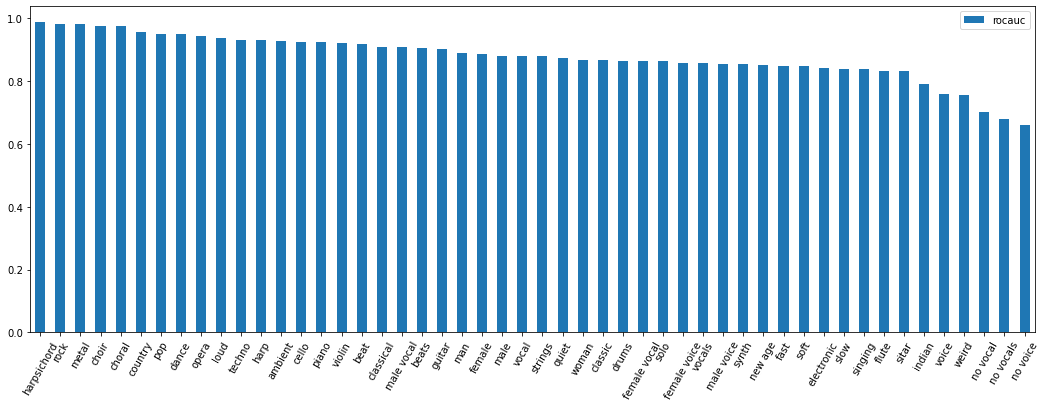

In [38]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task

In [39]:
print(pytorch_model_summary.summary(model, torch.zeros(16, 1, 48000).to('cuda'), show_input=True))

-------------------------------------------------------------------------
       Layer (type)          Input Shape         Param #     Tr. Param #
   MelSpectrogram-1       [16, 1, 48000]               0               0
    AmplitudeToDB-2     [16, 1, 96, 188]               0               0
      BatchNorm2d-3     [16, 1, 96, 188]               2               2
          Conv_2d-4     [16, 1, 96, 188]             192             192
          Conv_2d-5     [16, 16, 24, 47]           4,704           4,704
          Conv_2d-6      [16, 32, 8, 15]          18,624          18,624
          Conv_2d-7       [16, 64, 2, 5]          74,112          74,112
      Conv_1d_FCN-8      [16, 128, 1, 1]           6,550           6,550
Total params: 104,184
Trainable params: 104,184
Non-trainable params: 0
-------------------------------------------------------------------------


# Metric Learning

Metric learning is a paradigm of representation learning, in which proximity between the representations of items is optimized to correspond to a notion of similarity. 

Compared to the classification, metric learning can leverage more flexible forms of supervision, for example, two audio clips belong to the same artist or not, or have the same tempo or not. Search and recommender systems rely on similarity between songs, artists, albums, lyrics, tags, etc. Nearest neighbor classifiers use similarity to propagate information (eg, tags) from labeled to unlabeled data.


### Dataloader

In [40]:
import random
class TripletDataset(Dataset):
  def __init__(self, paths, id_to_path, input_length, binary, tags, split):
    """
    Args:
      paths (str): path to load dataset from
      id_to_path (Dict): track id to audio path
      input_length (int): sample_rate x duration (second) 
      binary (Pandas.DataFrame): binary matrix for audio (index: track_id, columns: tag binary)
      tags(list) : list of tag
      split (str): one of [TRAIN, VALID, TEST]
    """
    self.paths = paths
    self.id_to_path = id_to_path
    self.input_length = input_length
    self.tags = tags
    self.binary = binary
    self.split = split

  def __getitem__(self, index):
    if self.split in ["TRAIN","VALID"]:
      tag = random.choice(self.tags)
      tag_binary = self.binary[tag]
      positive_tracks = tag_binary[tag_binary != 0]
      negative_tracks = tag_binary[tag_binary == 0]
      anc_id, pos_id = positive_tracks.sample(2).index
      neg_id = negative_tracks.sample(1).index[0]

      anc_waveform = self.item_to_waveform(anc_id)
      pos_waveform = self.item_to_waveform(pos_id)
      neg_waveform = self.item_to_waveform(neg_id)
      return anc_waveform, pos_waveform, neg_waveform

    elif self.split == "TEST":
      item = self.binary.iloc[index]
      id = item.name
      path = os.path.join(self.paths, self.id_to_path[id].replace(".mp3",".npy"))
      waveform = np.load(path)
      chunk_number = waveform.shape[0] // self.input_length
      chunk = np.zeros((chunk_number, self.input_length))
      for idx in range(chunk.shape[0]):
        chunk[idx] = waveform[idx * input_length:(idx+1) * input_length] # Thanks for JoonkyuPark :)
      audio = chunk.astype(np.float32)
      label = item.values.astype(np.float32)
      return audio, label

  def item_to_waveform(self, id):
    path = os.path.join(self.paths, self.id_to_path[id].replace(".mp3", ".npy")) # pre-extract waveform, for fast loader
    waveform = np.load(path) 
    random_idx = np.random.randint(low=0, high=int(waveform.shape[0] - self.input_length))
    waveform = waveform[random_idx:random_idx+self.input_length] # extract input
    audio = np.expand_dims(waveform, axis = 0)# 1 x samples
    return audio.astype(np.float32)

  def __len__(self):
    if self.split in ["TRAIN","VALID"]:
      return len(self.binary) # it is tag wise sampling, so you can increase dataset length
    elif self.split == "TEST":
      return len(self.binary)

In [41]:
tr_data = TripletDataset(data_path, id_to_path, input_length, df_train, TAGS, "TRAIN")
va_data = TripletDataset(data_path, id_to_path, input_length, df_valid, TAGS, "VALID")
te_data = TripletDataset(data_path, id_to_path, input_length, df_test, TAGS, "TEST")
loader_train = DataLoader(tr_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = DataLoader(va_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(te_data, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

In [42]:
class LinearProjection(nn.Module):
  """
  Backbone model for linear proejction
  mel spectrogam to embedding
  """
  def __init__(self,
              sample_rate=16000,
              n_fft=512,
              f_min=0.0,
              f_max=8000.0,
              n_mels=96):
    """
    Args:
      sample_rate (int): path to load dataset from
      n_fft (int): number of samples for fft
      f_min (float): min freq
      f_max (float): max freq
      n_mels (float): number of mel bin
      n_class (int): number of class
    """
    super(LinearProjection, self).__init__()
    self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                      n_fft=n_fft,
                                                      f_min=f_min,
                                                      f_max=f_max,
                                                      n_mels=n_mels)
    self.to_db = torchaudio.transforms.AmplitudeToDB()
    self.spec_bn = nn.BatchNorm2d(1)
    self.embedding_size = 4096
    self.linear_proj = nn.Linear(n_mels * 188, self.embedding_size) # (freq * time) to embedding dim
    
  def forward(self, x):
    x = self.spec(x)
    x = self.to_db(x)
    x = self.spec_bn(x)
    x = x.squeeze(1)
    x = x.view(x.size(0), -1)
    embedding = self.linear_proj(x)
    return embedding

In [43]:
class TripletLoss(nn.Module):
  def __init__(self, margin):
    """
    Args:
      margin:
    """
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.relu = nn.ReLU()
    
  def forward(self, anchor, positive, negative):
    pos_sim = nn.CosineSimilarity(dim=-1)(anchor, positive)
    neg_sim = nn.CosineSimilarity(dim=-1)(anchor, negative)
    losses = self.relu(self.margin - pos_sim + neg_sim)
    return losses.mean()

### [Question 3] Implement the evaluation metric.
Implement a multi-label recall for metric learning. 
- https://arxiv.org/abs/2008.03729

If one of the top K retrieved results has the same class label as the query song, the recall@K is set to 1, otherwise it is set to 0. This process is repeated for all samples in the test set and then averaged. Our data is multi-labeled, however, so we adapt the standard single-label (multi-class) R@K metric to create a multi-label variant. Our definition is

$$
Recall@K = \frac{1}{N} \Sigma^{N}_{q=1} 
\frac{n(y^{q} \cap (\cup^{K}_{i=1}y^{i})}{n(y^{q})}
$$

where $N$ is the number of test samples, $y^{q}$ is the ground truth labels of a query, and $y^{i}$ is the ground truth labels of the top $K$ retrieved results. And, $n(·)$ denotes the number of the elements of a set. In this setup, if the set of labels of the top K retrieved results contains all the multiple labels of the query song, the recall@K is set to 1, otherwise it is set to the correct answer ratio. We report R@K when K is 1, 2, 4, and 8.

In [44]:
class Metric_Runner(object):
  def __init__(self, model, lr, momentum, weight_decay, sr):
    """
    Args:
      model (nn.Module): pytorch model
      lr (float): learning rate
      momentum (float): momentum
      weight_decay (float): weight_decay
      sr (float): stopping rate
    """
    self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=5, verbose=True)
    self.learning_rate = lr
    self.stopping_rate = sr
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model = model.to(self.device)
    self.criterion = TripletLoss(margin=0.4).to(self.device)

  # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
  def run(self, dataloader, epoch, mode='TRAIN'):
    self.model.train() if mode is 'TRAIN' else self.model.eval()

    epoch_loss = 0
    pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
    for item in pbar:
      # Move mini-batch to the desired device.
      anc, pos, neg = item
      anc_emb = self.model(anc.to(self.device))
      pos_emb = self.model(pos.to(self.device))
      neg_emb = self.model(neg.to(self.device))
      
      # Compute the loss.
      loss = self.criterion(anc_emb, pos_emb, neg_emb)
      if mode is 'TRAIN':
        # Perform backward propagation to compute gradients.
        loss.backward()
        # Update the parameters.
        self.optimizer.step()
        # Reset the computed gradients.
        self.optimizer.zero_grad()

      batch_size = anc_emb.shape[0]
      epoch_loss += batch_size * loss.item()
    epoch_loss = epoch_loss / len(dataloader.dataset)
    return epoch_loss

  def test(self, dataloader):
    self.model.eval()
    epoch_loss = 0
    embeddings, labels = [], []
    pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
    for waveform, label in pbar:
      waveform = waveform.transpose(1,0)
      with torch.no_grad():
        embedding = self.model(waveform.to(self.device))
      embeddings.append(embedding.mean(0,True).detach().cpu())
      labels.append(label)
    embeddings = torch.stack(embeddings).squeeze(1)
    labels = torch.stack(labels).squeeze(1)

    # calculate cosine similarity (if you use different distance metric, than you need to change this part)
    embedding_norm = embeddings / embeddings.norm(dim=-1, keepdim=True)
    sim_matrix = embedding_norm @ embedding_norm.T
    sim_matrix = sim_matrix.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    multilabel_recall = {
        "R@1" : self.multilabel_recall(sim_matrix, labels, top_k=1),
        "R@2" : self.multilabel_recall(sim_matrix, labels, top_k=2),
        "R@4" : self.multilabel_recall(sim_matrix, labels, top_k=4),
        "R@8" : self.multilabel_recall(sim_matrix, labels, top_k=8),
    }
    return multilabel_recall

  def multilabel_recall(self, sim_matrix, binary_labels, top_k):
    Multilabel_Recall=0    
    for i in range(binary_labels.shape[0]):
        indices = (-sim_matrix[i,:]).argsort()[:top_k+1]
        indices = np.delete(indices, np.where(indices==i))
        numerator  = np.sum(np.logical_and(binary_labels[i,:], np.any(binary_labels[indices,:], axis=0)))
        denominator = np.sum(binary_labels[i,:])
        Multilabel_Recall += numerator / denominator
    Multilabel_Recall /= binary_labels.shape[0]   
    return Multilabel_Recall

  # Early stopping function for given validation loss
  def early_stop(self, loss, epoch):
    self.scheduler.step(loss, epoch)
    self.learning_rate = self.optimizer.param_groups[0]['lr']
    stop = self.learning_rate < self.stopping_rate
    return stop

In [45]:
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
MOMENTUM = 0.9
NUM_EPOCHS = 3
WEIGHT_DECAY = 0.0
model = LinearProjection()
runner = Metric_Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR)
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(loader_train, epoch, 'TRAIN')
  valid_loss = runner.run(loader_valid, epoch, 'VALID')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break

TRAIN Epoch 00:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 00:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 1/3] [Train Loss: 0.3207] [Valid Loss: 0.3152]


TRAIN Epoch 01:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 01:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 2/3] [Train Loss: 0.3035] [Valid Loss: 0.2981]


TRAIN Epoch 02:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 02:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 3/3] [Train Loss: 0.3013] [Valid Loss: 0.2961]


In [46]:
multilabel_recall = runner.test(loader_test)

TEST:   0%|          | 0/1339 [00:00<?, ?it/s]

In [47]:
multilabel_recall

{'R@1': 0.4249034406801392,
 'R@2': 0.5613892310494248,
 'R@4': 0.6857871362725729,
 'R@8': 0.7821814647057352}

In [48]:
print(pytorch_model_summary.summary(model, torch.zeros(16, 1, 48000).to('cuda'), show_input=True))

-------------------------------------------------------------------------
       Layer (type)          Input Shape         Param #     Tr. Param #
   MelSpectrogram-1       [16, 1, 48000]               0               0
    AmplitudeToDB-2     [16, 1, 96, 188]               0               0
      BatchNorm2d-3     [16, 1, 96, 188]               2               2
           Linear-4          [16, 18048]      73,928,704      73,928,704
Total params: 73,928,706
Trainable params: 73,928,706
Non-trainable params: 0
-------------------------------------------------------------------------


### [Question 4] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* Change backbone model
  - https://arxiv.org/abs/1609.04243
  - https://arxiv.org/abs/1711.02520
  - https://arxiv.org/abs/2006.00751
* Change distance mesure
  - Euclidean distance
  - Cosine distance
* Change positive negative sampling
  - Tag based sampling
  - Timbre, Beat based sampling
  - Latent Space based sampling (SVD or Word Embedding)
  - Instance based sampling

In [49]:
# use 50 top tags
TAGS_re = [
    # Genre(12)
    'classic', 'techno', 'rock', 'indian', 'opera', 'country', 'metal', 'new age', 'dance', 'pop', 'electronic', 'classical',
    # Mood(5)
    'soft', 'quiet', 'loud', 'ambient', 'weird', 
    # Instrument(31)
    'harpsichord', 'sitar', 'flute', 'piano', 'guitar', 'strings', 'drums', 'violin', 'synth', 'harp', 'cello', 'beat', 'beats',
    'choral', 'vocal', 'vocals', 'no vocals', 'male vocal', 'female vocal', 'no vocal', 'solo',
    'female', 'male', 'singing', 'woman', 'man', 'choir', 'voice', 'male voice', 'no voice', 'female voice',
    # tempo (2)
    'slow', 'fast'
]

In [50]:
df_train = df_train[TAGS_re]
df_valid = df_valid[TAGS_re]
df_test = df_test[TAGS_re]

In [51]:
import random
class DisentangledTripletDataset(TripletDataset):
  def __getitem__(self, index):
    if self.split in ["TRAIN","VALID"]:
      tag = random.choice(self.tags)
      tag_binary = self.binary[tag]
      positive_tracks = tag_binary[tag_binary != 0]
      negative_tracks = tag_binary[tag_binary == 0]
      anc_id, pos_id = positive_tracks.sample(2).index
      neg_id = negative_tracks.sample(1).index[0]

      anc_waveform = self.item_to_waveform(anc_id)
      reg_waveform = self.item_to_waveform(anc_id) # track regularization
      pos_waveform = self.item_to_waveform(pos_id)
      neg_waveform = self.item_to_waveform(neg_id)
      return anc_waveform, reg_waveform, pos_waveform, neg_waveform, tag

    elif self.split == "TEST":
      item = self.binary.iloc[index]
      id = item.name
      path = os.path.join(self.paths, self.id_to_path[id].replace(".mp3",".npy"))
      waveform = np.load(path)
      chunk_number = waveform.shape[0] // self.input_length
      chunk = np.zeros((chunk_number, self.input_length))
      for idx in range(chunk.shape[0]):
        chunk[idx] = waveform[idx * input_length:(idx+1) * input_length]
      audio = chunk.astype(np.float32)
      label = item.values.astype(np.float32)
      return audio, label

In [52]:
tr_data = DisentangledTripletDataset(data_path, id_to_path, input_length, df_train, TAGS, "TRAIN")
va_data = DisentangledTripletDataset(data_path, id_to_path, input_length, df_valid, TAGS, "VALID")
te_data = DisentangledTripletDataset(data_path, id_to_path, input_length, df_test, TAGS, "TEST")
loader_train = DataLoader(tr_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = DataLoader(va_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(te_data, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

In [53]:
class Projection_Musicnn(nn.Module):
    def __init__(self,
                sample_rate=16000,
                n_fft=512,
                f_min=0.0,
                f_max=8000.0,
                n_mels=96,
                n_class=50,
                dataset='mtat'):
        super(Projection_Musicnn, self).__init__()

        # Spectrogram
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                         n_fft=n_fft,
                                                         f_min=f_min,
                                                         f_max=f_max,
                                                         n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)

        # Pons front-end
        m1 = Conv_V(1, 204, (int(0.7*96), 7))
        m2 = Conv_V(1, 204, (int(0.4*96), 7))
        m3 = Conv_H(1, 51, 129)
        m4 = Conv_H(1, 51, 65)
        m5 = Conv_H(1, 51, 33)
        self.layers = nn.ModuleList([m1, m2, m3, m4, m5])

        # Pons back-end
        backend_channel= 512 if dataset=='msd' else 64
        self.layer1 = Conv_1d_Musicnn(561, backend_channel, 7, 1, 1)
        self.layer2 = Conv_1d_Musicnn(backend_channel, backend_channel, 7, 1, 1)
        self.layer3 = Conv_1d_Musicnn(backend_channel, backend_channel, 7, 1, 1)
        self.layer4 = Conv_1d_FCN(1506, 256)
                                  
    def forward(self, x):
        # Spectrogram
        x = self.spec(x)
        x = self.to_db(x)
        x = self.spec_bn(x)

        # Pons front-end
        out = []
        for layer in self.layers:
            out.append(layer(x))
        out = torch.cat(out, dim=1)

        # Pons back-end
        length = out.size(2)
        res1 = self.layer1(out)
        res2 = self.layer2(res1) + res1
        res3 = self.layer3(res2) + res2
        out = torch.cat([out, res1, res2, res3], 1)

        mp = nn.MaxPool1d(length)(out)
        avgp = nn.AvgPool1d(length)(out)

        out = torch.cat([mp, avgp], dim=1)
        out = (torch.unsqueeze(out, 1)).permute(0, 2, 1, 3)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out

In [54]:
class Projection_CNN(nn.Module):
  def __init__(self,
              sample_rate=16000,
              n_fft=512,
              f_min=0.0,
              f_max=8000.0,
              n_mels=96):

    super(Projection_CNN, self).__init__()    
    self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                      n_fft=n_fft,
                                                      f_min=f_min,
                                                      f_max=f_max,
                                                      n_mels=n_mels)
    self.to_db = torchaudio.transforms.AmplitudeToDB()
    self.spec_bn = nn.BatchNorm2d(1)
    
    self.layer1 = Conv_2d(1, 256, 3, 1, 1, 4)
    self.layer2 = Conv_2d(256, 512, 3, 1, 1, 3)
    self.layer3 = Conv_2d(512, 1024, 3, 1, 1, 3)
    self.layer4 = Conv_2d(1024, 2048, 3, 1, 1, (2,5))    
    self.layer5 = Conv_1d_FCN(2048, 1024) 
    self.apply(self.init_params)
    
  def init_params(self, m):
    for m in self.modules(): 
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.GRU):
            torch.nn.init.xavier_normal_(m.weight)
            torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)    
            
  def forward(self, x):
    x = self.spec(x)
    x = self.to_db(x)
    x = self.spec_bn(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    embedding = x.view(x.size(0), -1)    
    
    return embedding

pretrained_model=Musicnn()
pretrained_model.load_state_dict(torch.load("Musicnn_pretrained.pth")) 

<All keys matched successfully>

In [55]:
class DisentangledTripletLoss(nn.Module):
  def __init__(self, margin):
    super(DisentangledTripletLoss, self).__init__()
    self.margin = margin
    self.relu = nn.ReLU()

  def forward(self, anchor, positive, negative, tag):    
    # mask function using similarity_notion
    mask = torch.zeros((anchor.shape[0],anchor.shape[1])).to('cuda')
    num_similarity_notion = 4
    evenly_occupied = int(anchor.shape[1]/num_similarity_notion)
    tag_i=0
    for i in tag:        
        tag_idx = TAGS_re.index(i)        
        mask_temp = torch.zeros((anchor.shape[1],))        
        if tag_idx<=11: # Genre(0-11)
            mask_temp[0:evenly_occupied]=1
        elif tag_idx>=12 and idx<=16: # Mood(12-16)
            mask_temp[evenly_occupied:evenly_occupied*2]=1
        elif tag_idx>=17 and idx<=47: # Instrument(17-47)
            mask_temp[evenly_occupied*2:evenly_occupied*3]=1
        elif tag_idx>=48 and idx<=49: # Tempo
            mask_temp[evenly_occupied*3:evenly_occupied*4]=1
        mask[tag_i,:]=mask_temp
        tag_i+=1
    
    anchor = anchor / anchor.norm(dim=-1, keepdim=True)
    positive = positive / positive.norm(dim=-1, keepdim=True)
    negative = negative / negative.norm(dim=-1, keepdim=True)  

    anchor = anchor*mask
    positive = positive*mask
    negative = negative*mask

    pos_sim = nn.CosineSimilarity(dim=-1)(anchor, positive)
    neg_sim = nn.CosineSimilarity(dim=-1)(anchor, negative)    
    
    losses = self.relu(self.margin - pos_sim + neg_sim)
    return losses.mean()

In [56]:
class TrackRegularizationLoss(nn.Module):
  def __init__(self, margin):
    super(TrackRegularizationLoss, self).__init__()
    self.margin = margin
    self.relu = nn.ReLU()

  def forward(self, anchor, regularizer, negative):    
    anchor = anchor / anchor.norm(dim=-1, keepdim=True)
    regularizer = regularizer / regularizer.norm(dim=-1, keepdim=True)
    negative = negative / negative.norm(dim=-1, keepdim=True)   
    
    pos_sim = nn.CosineSimilarity(dim=-1)(anchor, regularizer)
    neg_sim = nn.CosineSimilarity(dim=-1)(anchor, negative)
    
    losses = self.relu(self.margin - pos_sim + neg_sim)
    return losses.mean()

In [57]:
class Metric_Runner_Q4(Metric_Runner):
  def __init__(self, model, lr, sr, metric, disentangle):
    self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)    
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=2, verbose=True)
    self.learning_rate = lr
    self.stopping_rate = sr
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model = model.to(self.device)
    self.metric = metric
    self.disentangle = disentangle
    if self.metric=="euclidean" and disentangle==False:
        self.criterion = nn.TripletMarginLoss(margin=0.4, p=2).to(self.device) # Not Disentangled
    elif self.metric=="cosine" and disentangle==False:
        self.criterion = TripletLoss(margin=0.4).to(self.device)
    elif self.metric=="cosine" and disentangle==True:
        self.criterion = DisentangledTripletLoss(margin=0.4).to(self.device)  
    self.criterion_regularizer = TrackRegularizationLoss(margin=0.4).to(self.device)  
    
  def run(self, dataloader, epoch, mode='TRAIN'):
    self.model.train() if mode is 'TRAIN' else self.model.eval()

    epoch_loss = 0
    pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
    for item in pbar:
      # Move mini-batch to the desired device.
      anc, reg, pos, neg, tag = item
      anc_emb = self.model(anc.to(self.device))
      reg_emb = self.model(reg.to(self.device))
      pos_emb = self.model(pos.to(self.device))
      neg_emb = self.model(neg.to(self.device))
      
      # Compute the loss.
      if self.disentangle==False:
        loss = self.criterion(anc_emb, pos_emb, neg_emb)
      elif self.disentangle==True:
        loss = self.criterion(anc_emb, pos_emb, neg_emb, tag)      
      loss += 0.5*self.criterion_regularizer(anc_emb, reg_emb, neg_emb) # Track Regularization
        
      if mode is 'TRAIN':
        # Perform backward propagation to compute gradients.
        loss.backward()
        # Update the parameters.
        self.optimizer.step()
        # Reset the computed gradients.
        self.optimizer.zero_grad()

      batch_size = anc_emb.shape[0]
      epoch_loss += batch_size * loss.item()
    epoch_loss = epoch_loss / len(dataloader.dataset)
    return epoch_loss 

  def test(self, dataloader):
    self.model.eval()
    epoch_loss = 0
    embeddings, labels = [], []
    pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
    for waveform, label in pbar:
      waveform = waveform.transpose(1,0)
      with torch.no_grad():
        embedding = self.model(waveform.to(self.device))
      embeddings.append(embedding.mean(0,True).detach().cpu())
      labels.append(label)
    embeddings = torch.stack(embeddings).squeeze(1)
    labels = torch.stack(labels).squeeze(1)

    sim_matrix = torch.zeros(embeddings.shape[0], embeddings.shape[0])
    if self.metric=="euclidean":        
        for i in range(embeddings.shape[0]):
            sim_matrix[i,:]=torch.norm(embeddings[i,:]-embeddings, dim=1)    
        sim_matrix = -sim_matrix
        sim_matrix = sim_matrix.detach().cpu().numpy()
        
    elif self.metric=="cosine":
        embedding_norm = embeddings / embeddings.norm(dim=-1, keepdim=True)
        sim_matrix = embedding_norm @ embedding_norm.T
        sim_matrix = sim_matrix.detach().cpu().numpy() 
    labels = labels.detach().cpu().numpy()
    
    multilabel_recall = {
        "R@1" : self.multilabel_recall(sim_matrix, labels, top_k=1),
        "R@2" : self.multilabel_recall(sim_matrix, labels, top_k=2),
        "R@4" : self.multilabel_recall(sim_matrix, labels, top_k=4),
        "R@8" : self.multilabel_recall(sim_matrix, labels, top_k=8),
    }
    return multilabel_recall, embeddings

In [58]:
'''
# Training setup.
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
NUM_EPOCHS = 3
model = Projection_CNN()
'''

'\n# Training setup.\nLR = 1e-3  # learning rate\nSR = 1e-5  # stopping rate\nNUM_EPOCHS = 3\nmodel = Projection_CNN()\n'

In [59]:
# Training setup.
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
NUM_EPOCHS = 3
model = Projection_Musicnn()

pretrained_dict = pretrained_model.state_dict()
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

count=0
for child in model.children():
    if count < 7:
        for param in child.parameters():
            param.requires_grad = False    
    count+=1      

In [60]:
runner = Metric_Runner_Q4(model=model, lr = LR, sr = SR, metric="cosine", disentangle=True)
for epoch in range(NUM_EPOCHS):
  train_loss = runner.run(loader_train, epoch, 'TRAIN')
  valid_loss = runner.run(loader_valid, epoch, 'VALID')
  print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %
        (epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
  if runner.early_stop(valid_loss, epoch + 1):
    break

TRAIN Epoch 00:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 00:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 1/3] [Train Loss: 0.3531] [Valid Loss: 0.3530]


TRAIN Epoch 01:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 01:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 2/3] [Train Loss: 0.3440] [Valid Loss: 0.3474]


TRAIN Epoch 02:   0%|          | 0/387 [00:00<?, ?it/s]

VALID Epoch 02:   0%|          | 0/96 [00:00<?, ?it/s]

[Epoch 3/3] [Train Loss: 0.3425] [Valid Loss: 0.3517]


In [61]:
multilabel_recall, embedding_test = runner.test(loader_test)

TEST:   0%|          | 0/1339 [00:00<?, ?it/s]

In [62]:
multilabel_recall

{'R@1': 0.5049550234016252,
 'R@2': 0.6481974336343265,
 'R@4': 0.7715159974868705,
 'R@8': 0.8627445370163809}

In [63]:
embedding_test.shape

torch.Size([1339, 256])

In [64]:
print(pytorch_model_summary.summary(model, torch.zeros(16, 1, 48000).to('cuda'), show_input=True))

---------------------------------------------------------------------------
         Layer (type)          Input Shape         Param #     Tr. Param #
     MelSpectrogram-1       [16, 1, 48000]               0               0
      AmplitudeToDB-2     [16, 1, 96, 188]               0               0
        BatchNorm2d-3     [16, 1, 96, 188]               2               0
             Conv_V-4     [16, 1, 96, 188]          96,288               0
             Conv_V-5     [16, 1, 96, 188]          54,876               0
             Conv_H-6     [16, 1, 96, 188]           6,732               0
             Conv_H-7     [16, 1, 96, 188]           3,468               0
             Conv_H-8     [16, 1, 96, 188]           1,836               0
    Conv_1d_Musicnn-9       [16, 561, 188]         251,520               0
   Conv_1d_Musicnn-10        [16, 64, 188]          28,864               0
   Conv_1d_Musicnn-11        [16, 64, 188]          28,864               0
       Conv_1d_FCN-12   

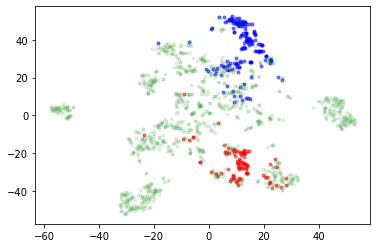

In [65]:
from matplotlib import pyplot as plt  
from sklearn.manifold import TSNE       
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(embedding_test) 

np_test=df_test.to_numpy()

plt.figure() 
new_coordinates = tsne_results[np.where(np_test[:,2])] # rock
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'bo', ms=3, alpha=.5)  
new_coordinates = tsne_results[np.where(np_test[:,4])] # opera
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'ro', ms=3, alpha=.5)      
new_coordinates = tsne_results[np.where((np_test[:,2]|np_test[:,4])!=1)] 
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'go', ms=3, alpha=.1)    

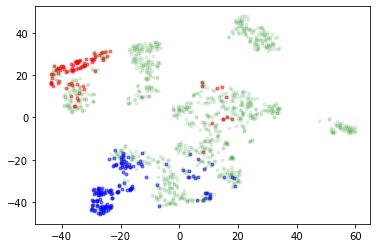

In [66]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(embedding_test[:,0:64]) 

plt.figure()  
new_coordinates = tsne_results[np.where(np_test[:,2])] # rock
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'bo', ms=3, alpha=.5)  
new_coordinates = tsne_results[np.where(np_test[:,4])] # opera
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'ro', ms=3, alpha=.5)      
new_coordinates = tsne_results[np.where((np_test[:,2]|np_test[:,4])!=1)] 
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'go', ms=3, alpha=.1)    

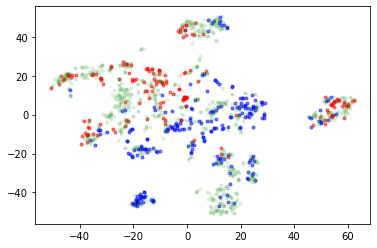

In [67]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(embedding_test) 

plt.figure() 
new_coordinates = tsne_results[np.where(np_test[:,48])]
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'bo', ms=3, alpha=.5)  
new_coordinates = tsne_results[np.where(np_test[:,49])] 
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'ro', ms=3, alpha=.5)      
new_coordinates = tsne_results[np.where((np_test[:,48]|np_test[:,49])!=1)] 
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'go', ms=3, alpha=.1)  

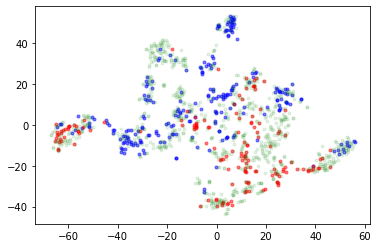

In [68]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(embedding_test[:,64*3:64*4]) 

plt.figure() 
new_coordinates = tsne_results[np.where(np_test[:,48])]
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'bo', ms=3, alpha=.5)  
new_coordinates = tsne_results[np.where(np_test[:,49])] 
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'ro', ms=3, alpha=.5)      
new_coordinates = tsne_results[np.where((np_test[:,48]|np_test[:,49])!=1)] 
plt.plot(new_coordinates[:,0], new_coordinates[:,1], 'go', ms=3, alpha=.1)  


# Deliverables
You should submit your Python code (`.ipynb` or `.py` files) and homework report (.pdf file) to KLMS. The report should include:
* Algorithm Description
* Experiments and Results
* Discussion

# Note
The code is written using PyTorch but you can use TensorFlow if you want.

# Credit
Thie homework was implemented by Jongpil Lee, Soonbeom Choi, Taejun Kim and SeungHeon Doh in the KAIST Music and Audio Computing Lab.
